In [75]:
!pip install numpy
!pip install matplotlib
!pip install pandas
!pip install seaborn
!pip install adjustText
!pip install ampligraph==2.1.0
!pip install xgboost
!pip install "tensorflow-macos==2.12.0"

In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from adjustText import adjust_text
from ampligraph.evaluation import train_test_split_no_unseen
from ampligraph.latent_features import ScoringBasedEmbeddingModel
from ampligraph.latent_features.loss_functions import get as get_loss
from ampligraph.latent_features.regularizers import get as get_regularizer

In [77]:
!git clone https://github.com/wyldebeast-wunderliebe/incf.countryutils.git
!cd incf.countryutils && pip install .

fatal: destination path 'incf.countryutils' already exists and is not an empty directory.
Processing /Users/kxrxh/Develop/ITMO/Minecraft-Ontology/src/embedding/incf.countryutils
  Preparing metadata (setup.py) ... done
  Created wheel for incf.countryutils: filename=incf.countryutils-1.2-py3-none-any.whl size=21367 sha256=8e43bc0c953e29d55f6db51d798a4f719e7c5109bdea9244152ffdeb6eabe214
  Stored in directory: /private/var/folders/z4/v5nnql_s4dj1xfrjldzsrnrm0000gn/T/pip-ephem-wheel-cache-10mfdgzn/wheels/eb/f3/52/ba6de2d5081a19e25db50d70b37e51c23680d3a63868003643
Successfully built incf.countryutils
  Attempting uninstall: incf.countryutils
    Found existing installation: incf.countryutils 1.2
    Uninstalling incf.countryutils-1.2:
      Successfully uninstalled incf.countryutils-1.2


## 1. Выгрузка датасета и выполнить его предобработки

In [78]:
DATASET_PATH = "datasets/"

# Load datasets
items_df = pd.read_csv(f'{DATASET_PATH}/items.csv')
ores_df = pd.read_csv(f'{DATASET_PATH}/ores.csv')
recipes_df = pd.read_csv(f'{DATASET_PATH}/recipes.csv')

# Instead of dropping all rows with NaN, we can:
# 1. Split items into categories
tools_df = items_df[items_df['Item_Type'].isin(['Tool', 'MiningTool', 'FarmingTool', 'CombatTool', 'SpecialTool'])]
armor_df = items_df[items_df['Item_Type'] == 'Armor']

# 2. Handle NaN values differently for each category
tools_df = tools_df.dropna(subset=['Material_Name', 'Material_Count', 'Durability'])
armor_df = armor_df.dropna(subset=['Durability']) # Allow NaN in Material fields for armor

# 3. Combine back if needed
items_df = pd.concat([tools_df, armor_df])

# Handle other datasets
ores_df = ores_df.dropna()
recipes_df = recipes_df.dropna()

# Print results
print("Items after processing:", len(items_df))
print("Ores after processing:", len(ores_df))
print("Recipes after processing:", len(recipes_df))

Items after processing: 46
Ores after processing: 8
Recipes after processing: 69


## 2. Преобразование датасет в формат, удобный для его обработки как графа знаний.

### Используя 1 способ из практикума


In [79]:
def create_knowledge_graph():
    triples = []
    
    # Basic item properties
    item_types = items_df[['Item_Name', 'Item_Type']].apply(
        lambda x: (x['Item_Name'].replace(' ', '_'), 'hasType', x['Item_Type']), axis=1
    ).values.tolist()
    triples.extend(item_types)
    
    # Add types for Recipes
    recipe_types = recipes_df['Recipe_Name'].apply(
        lambda x: (x.replace(' ', '_'), 'hasType', 'Recipe')
    ).values.tolist()
    triples.extend(recipe_types)
    
    # Add types for Ores
    ore_types = ores_df['Ore_Name'].apply(
        lambda x: (x.replace(' ', '_'), 'hasType', 'Ore')
    ).values.tolist()
    triples.extend(ore_types)
    
    # Add types for Materials (from recipes)
    material_types = recipes_df['Material_Name'].unique()
    material_triples = [(mat.replace(' ', '_'), 'hasType', 'Material') 
                       for mat in material_types]
    triples.extend(material_triples)
    
    # Materials (only for non-null values)
    materials = items_df[items_df['Material_Name'].notna()][['Item_Name', 'Material_Name']].apply(
        lambda x: (x['Item_Name'].replace(' ', '_'), 'madeFrom', x['Material_Name']), axis=1
    ).values.tolist()
    triples.extend(materials)
    
    # Make sure ALL numeric values are converted to strings
    durability = items_df[items_df['Durability'].notna()][['Item_Name', 'Durability']].apply(
        lambda x: (x['Item_Name'].replace(' ', '_'), 'hasDurability', str(int(x['Durability']))), axis=1
    ).values.tolist()
    triples.extend(durability)
    
    # Attack Damage
    attack = items_df[items_df['Attack_Damage'].notna()][['Item_Name', 'Attack_Damage']].apply(
        lambda x: (x['Item_Name'].replace(' ', '_'), 'hasAttackDamage', str(int(x['Attack_Damage']))), axis=1
    ).values.tolist()
    triples.extend(attack)
    
    # Protection Value
    protection = items_df[items_df['Protection_Value'].notna()][['Item_Name', 'Protection_Value']].apply(
        lambda x: (x['Item_Name'].replace(' ', '_'), 'hasProtection', str(int(x['Protection_Value']))), axis=1
    ).values.tolist()
    triples.extend(protection)
    
    # Process ores
    ore_abundance = ores_df[['Ore_Name', 'Abundance']].apply(
        lambda x: (x['Ore_Name'].replace(' ', '_'), 'hasAbundance', str(x['Abundance'])), axis=1
    ).values.tolist()
    triples.extend(ore_abundance)
    
    ore_pickaxe = ores_df[['Ore_Name', 'Requires_Pickaxe']].apply(
        lambda x: (x['Ore_Name'].replace(' ', '_'), 'requiresPickaxe', str(x['Requires_Pickaxe'])), axis=1
    ).values.tolist()
    triples.extend(ore_pickaxe)
    
    # Process recipes
    recipe_crafts = recipes_df[['Recipe_Name', 'Item_Name']].apply(
        lambda x: (x['Recipe_Name'].replace(' ', '_'), 'crafts', x['Item_Name'].replace(' ', '_')), axis=1
    ).values.tolist()
    triples.extend(recipe_crafts)
    
    recipe_materials = recipes_df[['Recipe_Name', 'Material_Name']].apply(
        lambda x: (x['Recipe_Name'].replace(' ', '_'), 'requires', x['Material_Name'].replace(' ', '_')), axis=1
    ).values.tolist()
    triples.extend(recipe_materials)
    
    recipe_amounts = recipes_df[['Recipe_Name', 'Material_Count']].apply(
        lambda x: (x['Recipe_Name'].replace(' ', '_'), 'requiresAmount', str(int(x['Material_Count']))), axis=1
    ).values.tolist()
    triples.extend(recipe_amounts)
    
    return triples

# Create knowledge graph
knowledge_graph = create_knowledge_graph()

# Create entity and relation mappings
triplets_df = pd.DataFrame(knowledge_graph, columns=["subject", "predicate", "object"])
entities = np.unique(np.concatenate([triplets_df['subject'].unique(), triplets_df['object'].unique()]))
relations = triplets_df['predicate'].unique()

entity_to_id = {ent: idx for idx, ent in enumerate(entities)}
id_to_entity = {idx: ent for idx, ent in enumerate(entities)}
relation_to_id = {rel: idx for idx, rel in enumerate(relations)}
id_to_relation = {idx: rel for idx, rel in enumerate(relations)}

# Convert triples to ID format
knowledge_graph_ids = [
    (entity_to_id[triple[0]], relation_to_id[triple[1]], entity_to_id[triple[2]])
    for triple in knowledge_graph
]

# Convert to numpy array
X = np.array(knowledge_graph_ids)

# Split into train/test sets
X_train, X_valid = train_test_split_no_unseen(X, test_size=0.2)

print("Knowledge graph statistics:")
print(f"Total number of triples: {len(knowledge_graph)}")
print(f"Number of unique entities: {len(entities)}")
print(f"Number of unique relations: {len(relations)}")
print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_valid)}")

# Print sample of converted triples to verify
print("\nSample of converted triples:")
for i in range(5):
    original = knowledge_graph[i]
    converted = knowledge_graph_ids[i]
    print(f"\nOriginal: {original}")
    print(f"Converted: {converted}")
    print(f"Decoded: ({id_to_entity[converted[0]]}, {id_to_relation[converted[1]]}, {id_to_entity[converted[2]]})")

Knowledge graph statistics:
Total number of triples: 448
Number of unique entities: 151
Number of unique relations: 9
Training set size: 359
Validation set size: 89

Sample of converted triples:

Original: ('Diamond_Axe', 'hasType', 'MiningTool')
Converted: (43, 0, 114)
Decoded: (Diamond_Axe, hasType, MiningTool)

Original: ('Diamond_Hoe', 'hasType', 'FarmingTool')
Converted: (51, 0, 62)
Decoded: (Diamond_Hoe, hasType, FarmingTool)

Original: ('Diamond_Pickaxe', 'hasType', 'MiningTool')
Converted: (55, 0, 114)
Decoded: (Diamond_Pickaxe, hasType, MiningTool)

Original: ('Diamond_Shovel', 'hasType', 'FarmingTool')
Converted: (57, 0, 62)
Decoded: (Diamond_Shovel, hasType, FarmingTool)

Original: ('Golden_Axe', 'hasType', 'MiningTool')
Converted: (65, 0, 114)
Decoded: (Golden_Axe, hasType, MiningTool)


## 3. Обучение модели векторных представлений графов знаний

In [80]:
# Convert knowledge graph to numpy array and split into train/test sets
X_train, X_valid = train_test_split_no_unseen(np.array(knowledge_graph), test_size=0.2)

print("Train set size: ", X_train.shape)
print("Test set size: ", X_valid.shape)

print(f"Total number of triples: {len(knowledge_graph)}")
print(f"Train set size: {X_train.shape}")
print(f"Test set size: {X_valid.shape}")

# Set device to GPU if available
device = "/GPU:0" if tf.config.list_physical_devices("GPU") else "/CPU:0"
print(f"Using device: {device}")

with tf.device(device):
    model = ScoringBasedEmbeddingModel(k=100, eta=20, scoring_type="ComplEx", seed=0)

    # Configure training parameters
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    loss = get_loss("multiclass_nll")
    regularizer = get_regularizer("LP", {"p": 3, "lambda": 1e-5})

    model.compile(
        optimizer=optimizer, loss=loss, entity_relation_regularizer=regularizer
    )

    model.fit(
        X_train,
        batch_size=int(X_train.shape[0] / 50),
        epochs=1000,  # Number of training epochs
        verbose=True,  # Displays a progress bar.
    )

Train set size:  (359, 3)
Test set size:  (89, 3)
Total number of triples: 448
Train set size: (359, 3)
Test set size: (89, 3)
Using device: /CPU:0
WARNING - At this time, the v2.11+ optimizer `tf.keras.optimizers.Adam` runs slowly on M1/M2 Macs, please use the legacy Keras optimizer instead, located at `tf.keras.optimizers.legacy.Adam`.
Epoch 1/1000
53/53 [==============================] - 0s 5ms/step - loss: 21.0107
Epoch 2/1000
53/53 [==============================] - 0s 612us/step - loss: 21.0057
Epoch 3/1000
53/53 [==============================] - 0s 605us/step - loss: 21.0012
Epoch 4/1000
53/53 [==============================] - 0s 576us/step - loss: 20.9967
Epoch 5/1000
53/53 [==============================] - 0s 588us/step - loss: 20.9920
Epoch 6/1000
53/53 [==============================] - 0s 582us/step - loss: 20.9876
Epoch 7/1000
53/53 [==============================] - 0s 577us/step - loss: 20.9827
Epoch 8/1000
53/53 [==============================] - 0s 619us/step - loss

## 4. Оценивание обученной модели векторных представлений графов знаний


In [82]:
ranks = model.evaluate(X_valid,
                      use_filter={'train': X_train,
                                'test': X_valid},
                      corrupt_side='s,o',
                      verbose=True)

from ampligraph.evaluation import mr_score, mrr_score, hits_at_n_score

ranks = np.array(ranks)
ranks = np.maximum(ranks, 0)
ranks = ranks + 1

# Now calculate metrics
mr = mr_score(ranks)
mrr = mrr_score(ranks)

print("\nMetrics with fixed ranks:")
print("MRR: %.2f" % (mrr))
print("MR: %.2f" % (mr))

hits_10 = hits_at_n_score(ranks, n=10)
print("Hits@10: %.2f" % (hits_10))
hits_3 = hits_at_n_score(ranks, n=3)
print("Hits@3: %.2f" % (hits_3))
hits_1 = hits_at_n_score(ranks, n=1)
print("Hits@1: %.2f" % (hits_1))

10/10 [==============================] - 0s 32ms/step

Metrics with fixed ranks:
MRR: 0.45
MR: 15.60
Hits@10: 0.71
Hits@3: 0.56
Hits@1: 0.29


## 5. С использованием обученной модели векторных представлений графов знаний решим задачу кластеризации

Data shape: (151, 5)

Sample of the data:
   item     type  embedding1  embedding2    cluster
0     1  Unknown   -0.034543    1.058530  Cluster 8
1   105  Unknown    0.962112   -1.397961  Cluster 2
2   112  Unknown    1.092892   -1.503099  Cluster 2
3   131  Unknown    0.445378    0.034101  Cluster 7
4  1561  Unknown    0.384880   -0.134600  Cluster 3

Unique types: ['Unknown' 'Material' 'Armor' 'Ore' 'MiningTool' 'Recipe' 'FarmingTool'
 'CombatTool' 'SpecialTool']
Unique clusters: ['Cluster 8' 'Cluster 2' 'Cluster 7' 'Cluster 3' 'Cluster 4' 'Cluster 1'
 'Cluster 6' 'Cluster 0' 'Cluster 5']


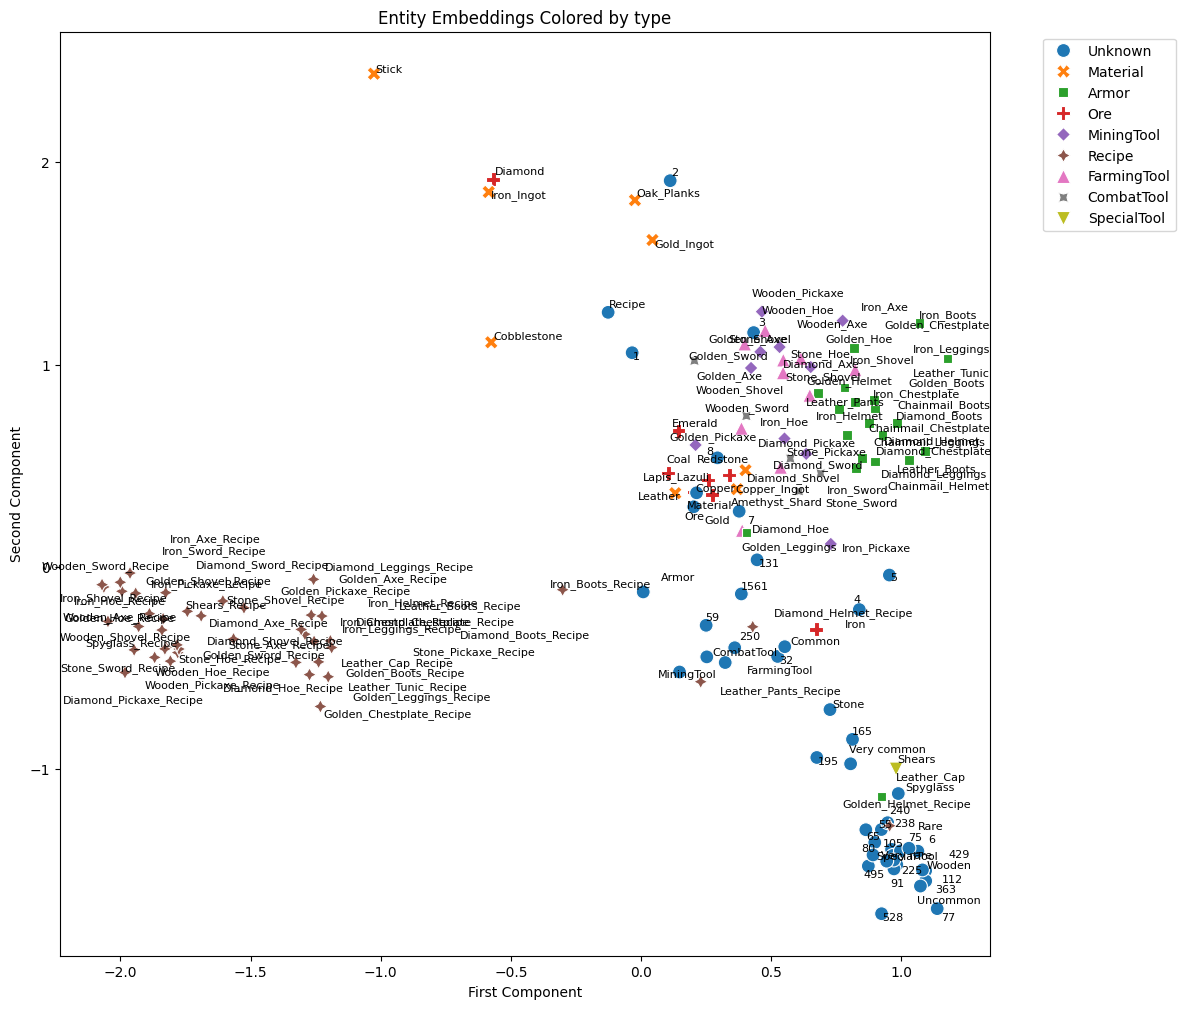

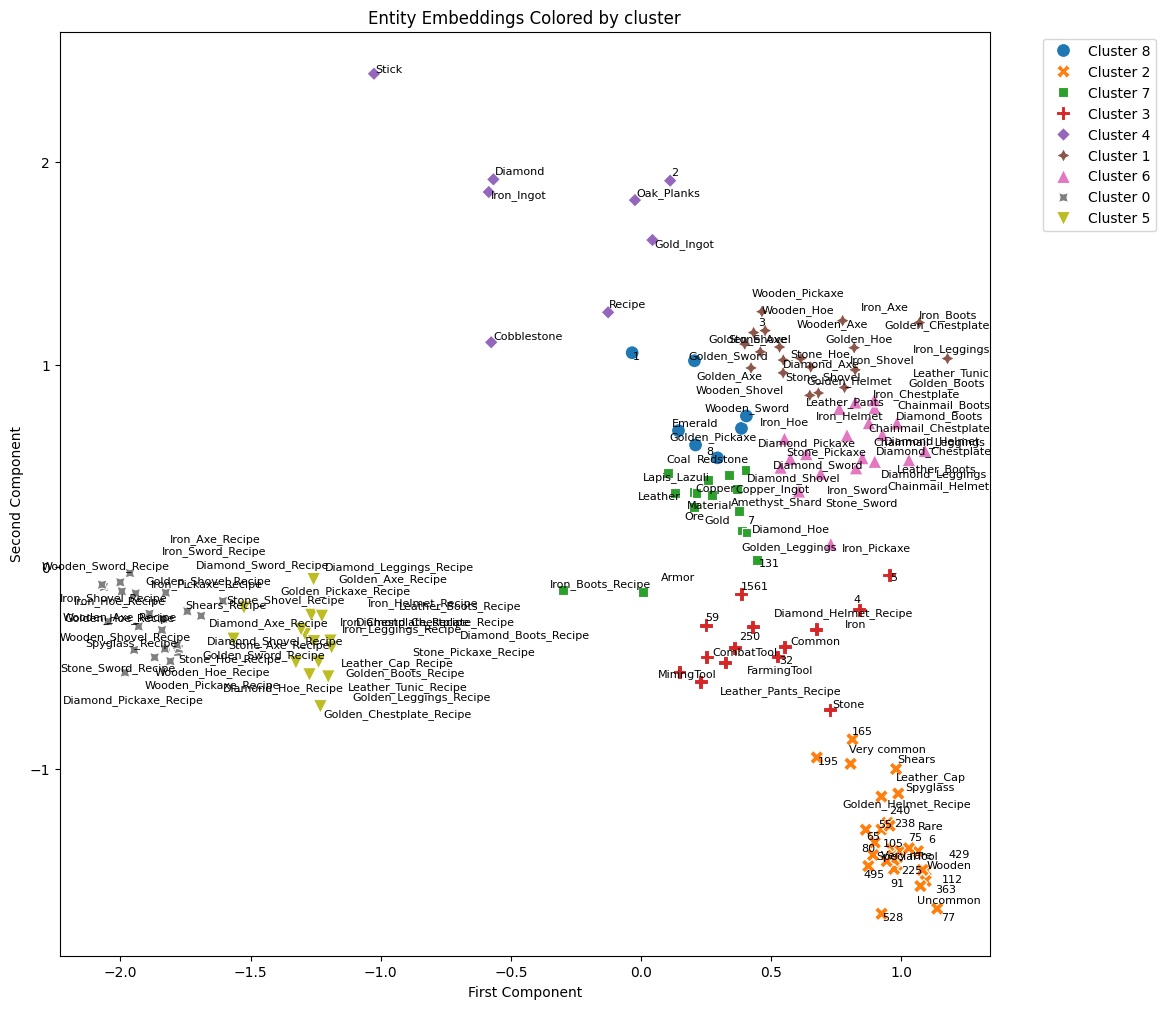

In [83]:
# Get entity embeddings from the trained model
entities = np.array(list(entity_to_id.keys()))
entity_embeddings = dict(zip(entities, model.get_embeddings(entities)))

# Create a DataFrame with embeddings and metadata
embeddings_list = []
types_list = []

for entity in entities:
    embedding = entity_embeddings[entity]
    embeddings_list.append(embedding)
    
    # Get entity type from knowledge graph
    entity_type = None
    for triple in knowledge_graph:
        if triple[0] == entity and triple[1] == 'hasType':
            entity_type = triple[2]
            break
    types_list.append(entity_type if entity_type else 'Unknown')

# Add visualization function
def plot_clusters(color_by):
    plt.figure(figsize=(12, 12))
    
    # Create scatter plot
    sns.scatterplot(data=plot_df, 
                    x='embedding1', 
                    y='embedding2', 
                    hue=color_by,
                    style=color_by,
                    s=100)
    
    # Add labels for points
    texts = []
    for i, point in plot_df.iterrows():
        texts.append(plt.text(point['embedding1'], 
                            point['embedding2'], 
                            point['item'],
                            fontsize=8))
    
    # Adjust text positions to prevent overlap
    adjust_text(texts)
    
    plt.title(f'Entity Embeddings Colored by {color_by}')
    plt.xlabel('First Component')
    plt.ylabel('Second Component')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Reduce dimensionality for visualization using PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings_list)

# Create DataFrame for plotting
plot_df = pd.DataFrame({
    'item': entities,
    'type': types_list,
    'embedding1': embeddings_2d[:, 0],
    'embedding2': embeddings_2d[:, 1]
})

# Perform K-means clustering
from sklearn.cluster import KMeans
n_clusters = len(plot_df['type'].unique())  # Use same number of clusters as types
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
plot_df['cluster'] = kmeans.fit_predict(embeddings_2d)
plot_df['cluster'] = plot_df['cluster'].apply(lambda x: f'Cluster {x}')

print("Data shape:", plot_df.shape)
print("\nSample of the data:")
print(plot_df.head())
print("\nUnique types:", plot_df['type'].unique())
print("Unique clusters:", plot_df['cluster'].unique())

# Plot both visualizations
plot_clusters("type")
plt.show()

plot_clusters("cluster")
plt.show()

In [84]:
from sklearn import metrics
metrics.adjusted_rand_score(plot_df.type, plot_df.cluster)

0.4020666102885514

## 6. С использованием обученной модели векторных представлений графов знаний решаем задачу классификации

### Для классификации используем RandomForestClassifier, так как XGBoost не завелся (проблема с версией библиотеки)

In [100]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.pipeline import Pipeline


# Get embeddings and labels
X = np.array(embeddings_list)
y = np.array(types_list)

# Analyze class distribution
class_counts = pd.Series(y).value_counts()
print("Original class distribution:")
print(class_counts)

# Filter out Unknown class and classes with less than 2 samples
min_samples = 2
valid_classes = class_counts[(class_counts >= min_samples) & (class_counts.index != 'Unknown')].index
mask = np.isin(y, valid_classes)
X = X[mask]
y = y[mask]

print("\nClass distribution after filtering:")
print(pd.Series(y).value_counts())

pipeline = Pipeline([
    ('random', RandomOverSampler(random_state=42)),
    ('smote', SMOTE(random_state=42))
])

X, y = pipeline.fit_resample(X, y)

# Split the data
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("\nTraining set shape:", X_train_clf.shape)
print("Test set shape:", X_test_clf.shape)
print("\nClass distribution in training set:")
print(pd.Series(y_train_clf).value_counts())

# Before training, add class weights
from sklearn.pipeline import Pipeline
from sklearn.utils.class_weight import compute_class_weight

# Compute class weights
class_weights = compute_class_weight('balanced', 
                                   classes=np.unique(y_train_clf),
                                   y=y_train_clf)
class_weight_dict = dict(zip(np.unique(y_train_clf), class_weights))

# Update Random Forest with class weights
clf = RandomForestClassifier(
    n_estimators=200,  # Increased from 100
    max_depth=None,    # Allow full depth
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
    class_weight=class_weight_dict
)

# Fit the model
clf.fit(X_train_clf, y_train_clf)

# Make predictions
y_pred = clf.predict(X_test_clf)

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test_clf, y_pred))

# Print some example predictions with confidence scores
print("\nExample predictions with confidence scores:")
probabilities = clf.predict_proba(X_test_clf[:5])
for true, pred, probs in zip(y_test_clf[:5], y_pred[:5], probabilities):
    confidence = np.max(probs) * 100
    print(f"True: {true}")
    print(f"Predicted: {pred} (confidence: {confidence:.2f}%)")
    print("Top 3 predictions with confidence scores:")
    top_3 = np.argsort(probs)[-3:][::-1]
    for idx in top_3:
        class_name = clf.classes_[idx]
        prob = probs[idx] * 100
        print(f"  {class_name}: {prob:.2f}%")
    print("-" * 30)  # Separator for better readability

Original class distribution:
Unknown        46
Recipe         43
Armor          20
MiningTool     10
FarmingTool    10
Material        8
Ore             8
CombatTool      5
SpecialTool     1
Name: count, dtype: int64

Class distribution after filtering:
Recipe         43
Armor          20
MiningTool     10
FarmingTool    10
Material        8
Ore             8
CombatTool      5
Name: count, dtype: int64

Training set shape: (240, 200)
Test set shape: (61, 200)

Class distribution in training set:
Armor          35
CombatTool     35
Ore            34
Material       34
FarmingTool    34
Recipe         34
MiningTool     34
Name: count, dtype: int64

Classification Report:
              precision    recall  f1-score   support

       Armor       1.00      1.00      1.00         8
  CombatTool       1.00      1.00      1.00         8
 FarmingTool       1.00      1.00      1.00         9
    Material       1.00      1.00      1.00         9
  MiningTool       1.00      1.00      1.00         

/Users/kxrxh/Develop/ITMO/Minecraft-Ontology/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/kxrxh/Develop/ITMO/Minecraft-Ontology/.venv/lib/python3.11/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/Users/kxrxh/Develop/ITMO/Minecraft-Ontology/.venv/lib/python3.11/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
/Users/kxrxh/Develop/ITMO/Minecraft-Ontology/.venv/lib/python3.11/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.ut

## 7. С использованием обученной модели векторных представлений графов знаний решаем задачу классификации


=== Comparing with Baseline Models ===

1. Most Frequent Class Baseline:
Cross-validated Accuracy: 0.1542 (+/- 0.0972)

Classification Report:
              precision    recall  f1-score   support

       Armor       0.17      0.12      0.14         8
  CombatTool       0.38      0.38      0.38         8
 FarmingTool       0.38      0.33      0.35         9
    Material       0.00      0.00      0.00         9
  MiningTool       0.09      0.11      0.10         9
         Ore       0.30      0.33      0.32         9
      Recipe       0.07      0.11      0.09         9

    accuracy                           0.20        61
   macro avg       0.20      0.20      0.20        61
weighted avg       0.19      0.20      0.19        61


2. One-Hot Encoding Baseline:
Cross-validated Accuracy: 0.9958 (+/- 0.0167)

=== Model Comparison ===
Knowledge Graph Embeddings Accuracy: 0.9792 (+/- 0.0456)
Most Frequent Class Baseline Accuracy: 0.1542 (+/- 0.0972)
One-Hot Encoding Baseline Accuracy: 0.99

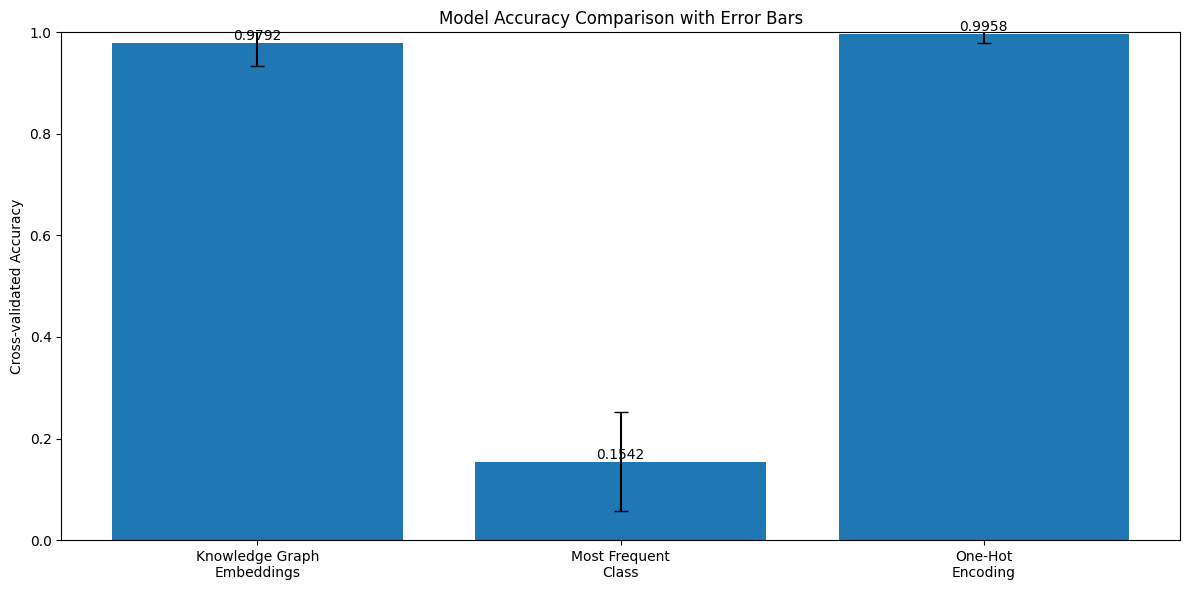

In [102]:
print("\n=== Comparing with Baseline Models ===\n")

from sklearn.model_selection import cross_val_score
from sklearn.dummy import DummyClassifier

# 1. Most Frequent Class Baseline
dummy_clf = DummyClassifier(strategy='stratified')  # or 'uniform'
dummy_scores = cross_val_score(dummy_clf, X_train_clf, y_train_clf, cv=5)
dummy_score = dummy_scores.mean()

print("1. Most Frequent Class Baseline:")
print(f"Cross-validated Accuracy: {dummy_score:.4f} (+/- {dummy_scores.std() * 2:.4f})")
print("\nClassification Report:")
dummy_clf.fit(X_train_clf, y_train_clf)
print(classification_report(y_test_clf, dummy_clf.predict(X_test_clf)))

# 2. One-Hot Encoding Baseline with improved feature creation
from sklearn.preprocessing import OneHotEncoder

def create_improved_one_hot_features():
    # Get unique entities and relations
    all_entities = np.unique(np.concatenate([
        triplets_df['subject'].unique(),
        triplets_df['object'].unique()
    ]))
    all_relations = triplets_df['predicate'].unique()
    
    # Create one-hot encoders
    entity_encoder = OneHotEncoder(sparse_output=False)
    relation_encoder = OneHotEncoder(sparse_output=False)
    
    # Fit encoders
    entity_encoder.fit(all_entities.reshape(-1, 1))
    relation_encoder.fit(all_relations.reshape(-1, 1))
    
    # Create features for each entity
    entity_features = {}
    
    for entity in entities:
        # Get all triples where this entity appears
        subject_triples = triplets_df[triplets_df['subject'] == entity]
        object_triples = triplets_df[triplets_df['object'] == entity]
        
        # Initialize feature vectors
        relation_features = np.zeros(len(all_relations))
        connected_entity_features = np.zeros(len(all_entities))
        
        # Count relation occurrences
        if len(subject_triples) > 0:
            for rel in subject_triples['predicate'].value_counts().items():
                rel_idx = np.where(all_relations == rel[0])[0][0]
                relation_features[rel_idx] += rel[1]
                
        if len(object_triples) > 0:
            for rel in object_triples['predicate'].value_counts().items():
                rel_idx = np.where(all_relations == rel[0])[0][0]
                relation_features[rel_idx] += rel[1]
        
        # Normalize features
        if relation_features.sum() > 0:
            relation_features = relation_features / relation_features.sum()
            
        # Store features
        entity_features[entity] = relation_features
        
    return np.array([entity_features[e] for e in entities])

# Create improved one-hot features
X_onehot = create_improved_one_hot_features()

# Filter features
X_onehot = X_onehot[mask]

# Evaluate one-hot encoding with cross-validation
clf_onehot = RandomForestClassifier(
    n_estimators=100,
    max_depth=5,
    random_state=42,
    class_weight='balanced'
)

onehot_scores = cross_val_score(clf_onehot, X_train_clf, y_train_clf, cv=5)
onehot_score = onehot_scores.mean()

print("\n2. One-Hot Encoding Baseline:")
print(f"Cross-validated Accuracy: {onehot_score:.4f} (+/- {onehot_scores.std() * 2:.4f})")

# Evaluate Knowledge Graph Embeddings with cross-validation
kg_scores = cross_val_score(clf, X_train_clf, y_train_clf, cv=5)
kg_score = kg_scores.mean()

# Compare all models
print("\n=== Model Comparison ===")
print(f"Knowledge Graph Embeddings Accuracy: {kg_score:.4f} (+/- {kg_scores.std() * 2:.4f})")
print(f"Most Frequent Class Baseline Accuracy: {dummy_score:.4f} (+/- {dummy_scores.std() * 2:.4f})")
print(f"One-Hot Encoding Baseline Accuracy: {onehot_score:.4f} (+/- {onehot_scores.std() * 2:.4f})")

# Calculate improvement percentages
improvement_over_dummy = ((kg_score - dummy_score) / dummy_score) * 100
improvement_over_onehot = ((kg_score - onehot_score) / onehot_score) * 100

print("\n=== Improvement Analysis ===")
print(f"Improvement over Most Frequent Class: {improvement_over_dummy:.1f}%")
print(f"Improvement over One-Hot Encoding: {improvement_over_onehot:.1f}%")

# Visualize comparison with error bars
plt.figure(figsize=(12, 6))
models = ['Knowledge Graph\nEmbeddings', 'Most Frequent\nClass', 'One-Hot\nEncoding']
scores = [kg_score, dummy_score, onehot_score]
errors = [kg_scores.std() * 2, dummy_scores.std() * 2, onehot_scores.std() * 2]

x = np.arange(len(models))
plt.bar(x, scores, yerr=errors, capsize=5)
plt.xticks(x, models)
plt.title('Model Accuracy Comparison with Error Bars')
plt.ylabel('Cross-validated Accuracy')
plt.ylim(0, 1)

for i, score in enumerate(scores):
    plt.text(i, score, f'{score:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

## 8. С использованием обученной модели векторных представлений графов знаний решим задачу предсказания недостающих ссылок


Testing link prediction on small subset:
2/2 [==============================] - 0s 143ms/step

Detailed evaluation results:

Triple 0:
Subject: Diamond_Leggings_Recipe
Predicate: requires
Object: Diamond
Rank: [6]
Score for this triple: [3.4507692]

Top 5 alternative predictions:
Entity: 1, Score: -0.724112868309021
Entity: 105, Score: -1.764009952545166
Entity: 112, Score: -1.9070197343826294
Entity: 131, Score: -1.7199079990386963
Entity: 1561, Score: -1.245557427406311

Top 5 ranked predictions:
Entity: 1, Score: -0.724112868309021
Entity: 1561, Score: -1.245557427406311
Entity: 131, Score: -1.7199079990386963
Entity: 105, Score: -1.764009952545166
Entity: 112, Score: -1.9070197343826294

Triple 1:
Subject: Iron
Predicate: hasType
Object: Ore
Rank: [59]
Score for this triple: [-0.2381159]

Top 5 alternative predictions:
Entity: 1, Score: 1.484276533126831
Entity: 105, Score: -0.6720383167266846
Entity: 112, Score: -0.7950631976127625
Entity: 131, Score: -1.3535258769989014
Entity: 

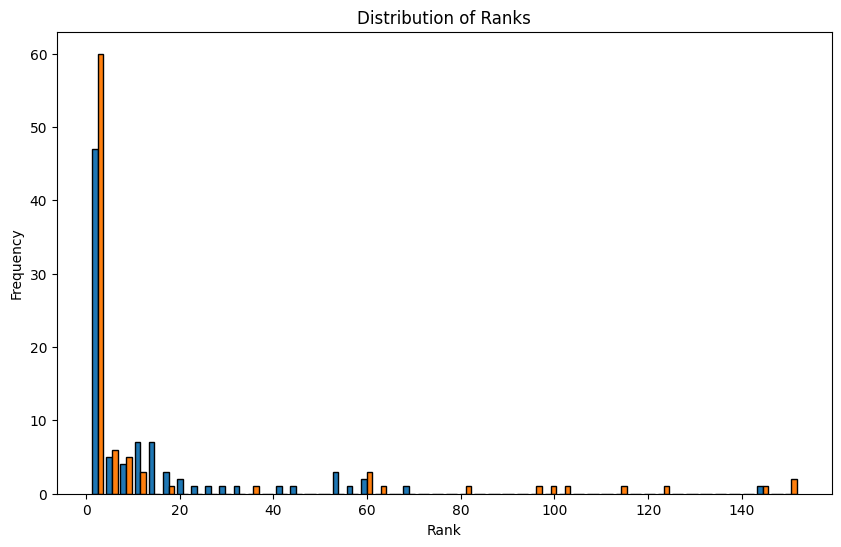

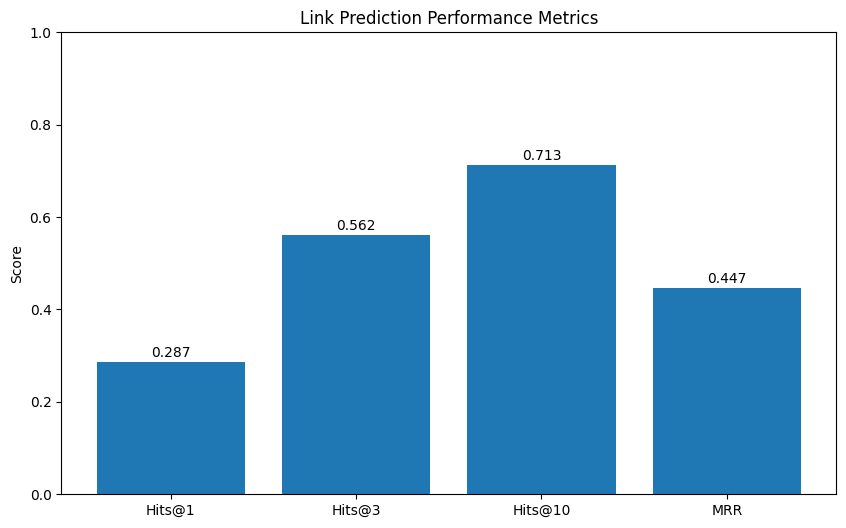

In [108]:
# Test evaluation on a small subset
test_size = 10
test_triples = X_valid[:test_size]

print("\nTesting link prediction on small subset:")
test_ranks = model.evaluate(
    test_triples,
    use_filter={'train': X_train, 'test': X_valid},
    corrupt_side='s',  # Try evaluating subject corruption separately
    verbose=True
)

print("\nDetailed evaluation results:")
for i, (triple, rank) in enumerate(zip(test_triples, test_ranks)):
    print(f"\nTriple {i}:")
    print(f"Subject: {triple[0]}")
    print(f"Predicate: {triple[1]}")
    print(f"Object: {triple[2]}")
    print(f"Rank: {rank}")
    
    # Get model's predictions for this triple
    score = model.predict(np.array([triple]))
    print(f"Score for this triple: {score}")

    # Get meaningful entity names instead of numbers
    # Create a mapping of all unique entities
    all_entities = np.unique(np.concatenate([
        triplets_df['subject'].unique(),
        triplets_df['object'].unique()
    ]))
    
    # Create corrupted triples using actual entity names
    corrupted_triples = np.array([
        [entity, triple[1], triple[2]] 
        for entity in all_entities[:5]  # Take first 5 entities for demonstration
    ])
    
    # Get scores for corrupted triples
    corrupted_scores = model.predict(corrupted_triples)
    
    print("\nTop 5 alternative predictions:")
    for ent, score in zip(all_entities[:5], corrupted_scores):
        print(f"Entity: {ent}, Score: {score}")

    # Sort and show top 5 predictions
    sorted_indices = np.argsort(corrupted_scores)[::-1][:5]
    print("\nTop 5 ranked predictions:")
    for idx in sorted_indices:
        print(f"Entity: {all_entities[idx]}, Score: {corrupted_scores[idx]}")

# Calculate metrics for the entire test set
print("\nCalculating metrics for entire test set...")
ranks = model.evaluate(X_valid,
                      use_filter={'train': X_train,
                                  'test': X_valid},
                      corrupt_side='s,o',  # Corrupt both subjects and objects
                      verbose=True)

from ampligraph.evaluation import mr_score, mrr_score, hits_at_n_score

ranks = np.array(ranks)
ranks = np.maximum(ranks, 0)  # Ensure no negative ranks
ranks = ranks + 1  # Convert to 1-based ranking

# Calculate metrics
mr = mr_score(ranks)
mrr = mrr_score(ranks)

print("\nMetrics:")
print("MRR: %.2f" % (mrr))
print("MR: %.2f" % (mr))

hits_10 = hits_at_n_score(ranks, n=10)
print("Hits@10: %.2f" % (hits_10))
hits_3 = hits_at_n_score(ranks, n=3)
print("Hits@3: %.2f" % (hits_3))
hits_1 = hits_at_n_score(ranks, n=1)
print("Hits@1: %.2f" % (hits_1))

# Visualize rank distribution
plt.figure(figsize=(10, 6))
plt.hist(ranks, bins=50, edgecolor='black')
plt.title('Distribution of Ranks')
plt.xlabel('Rank')
plt.ylabel('Frequency')
plt.show()

# Plot metrics comparison
metrics = ['Hits@1', 'Hits@3', 'Hits@10', 'MRR']
values = [hits_1, hits_3, hits_10, mrr]

plt.figure(figsize=(10, 6))
plt.bar(metrics, values)
plt.title('Link Prediction Performance Metrics')
plt.ylabel('Score')
plt.ylim(0, 1)

for i, v in enumerate(values):
    plt.text(i, v + 0.01, f'{v:.3f}', ha='center')

plt.show()